In [2]:
import os
import copy
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from torchsummary import summary
from fastprogress import progress_bar
from auto_encoder import encode_images, decode_images

Loaded VAE!


Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


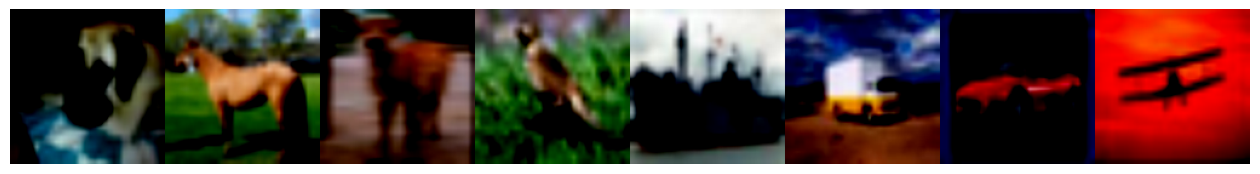

In [3]:
# define image transformation
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((128, 128)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# download dataset
train_dataset = torchvision.datasets.CIFAR10(root='dataset', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)

# extract a batch of images
batch_images, batch_labels = next(iter(train_loader))
# display a grid of images
plt.figure(figsize=(16, 12))
plt.imshow(np.transpose(torchvision.utils.make_grid(batch_images[:8], padding=0).numpy(), (1, 2, 0)))
plt.axis('off')
plt.show()

In [4]:
sample_latent = encode_images(batch_images)
print('Latent image shape:', sample_latent.shape)

Latent image shape: torch.Size([256, 4, 16, 16])


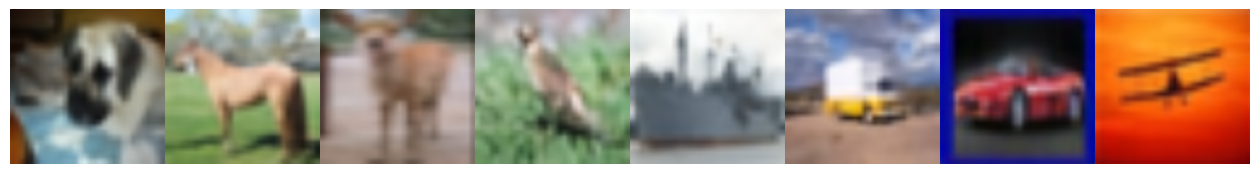

In [5]:
sample_reconstruction = decode_images(sample_latent)
sample_reconstruction = (sample_reconstruction.clamp(-1, 1) + 1) / 2
sample_reconstruction = (sample_reconstruction * 255).type(torch.uint8)

# display a reconstructed images
plt.figure(figsize=(16, 12))
plt.imshow(np.transpose(torchvision.utils.make_grid(sample_reconstruction[:8], padding=0).cpu().numpy(), (1, 2, 0)))
plt.axis('off')
plt.show()

In [6]:
class SelfAttention(torch.nn.Module):
    def __init__(self, channels):
        super(SelfAttention, self).__init__()
        self.channels = channels
        self.mha = torch.nn.MultiheadAttention(channels, num_heads=1, batch_first=True)
        self.ln = torch.nn.LayerNorm([channels])
        self.ff_self = torch.nn.Sequential(
            torch.nn.LayerNorm([channels]),
            torch.nn.Linear(channels, channels),
            torch.nn.GELU(),
            torch.nn.Linear(channels, channels),
        )

    def forward(self, x):
        size = x.shape[-1]
        x = x.view(-1, self.channels, size * size).swapaxes(1, 2)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value.swapaxes(2, 1).view(-1, self.channels, size, size)

In [7]:
class DoubleConv(torch.nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super().__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            torch.nn.GroupNorm(1, mid_channels),
            torch.nn.GELU(),
            torch.nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            torch.nn.GroupNorm(1, out_channels)
        )

    def forward(self, x):
        if self.residual:
            return torch.nn.functional.gelu(x + self.double_conv(x))
        else:
            return self.double_conv(x)

In [8]:
class Down(torch.nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()
        self.max_pool_conv = torch.nn.Sequential(
            torch.nn.MaxPool2d(2),
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels)
        )

        self.emb_layer = torch.nn.Sequential(
            torch.nn.SiLU(),
            torch.nn.Linear(emb_dim, out_channels)
        )

    def forward(self, x, t):
        x = self.max_pool_conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb

In [9]:
class Up(torch.nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()

        self.up = torch.nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv = torch.nn.Sequential(
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels, in_channels // 2)
        )

        self.emb_layer = torch.nn.Sequential(
            torch.nn.SiLU(),
            torch.nn.Linear(emb_dim, out_channels)
        )

    def forward(self, x, skip_x, t):
        x = self.up(x)
        x = torch.cat([skip_x, x], dim=1)
        x = self.conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb

In [10]:
class UNetTransformer(torch.nn.Module):
    def __init__(self, c_in=3, c_out=3, time_dim=256, num_classes=None):
        super().__init__()
        # embeddings
        self.time_dim = time_dim
        self.label_emb = torch.nn.Embedding(num_classes, time_dim)
        # encoder
        self.inc = DoubleConv(c_in, 64)
        self.down1 = Down(64, 128)
        self.sa1 = SelfAttention(128)
        self.down2 = Down(128, 256)
        self.sa2 = SelfAttention(256)
        self.down3 = Down(256, 256)
        self.sa3 = SelfAttention(256)
        # bottleneck
        self.bot1 = DoubleConv(256, 512)
        self.bot2 = DoubleConv(512, 256)
        # decoder
        self.up1 = Up(512, 128)
        self.sa4 = SelfAttention(128)
        self.up2 = Up(256, 64)
        self.sa5 = SelfAttention(64)
        self.up3 = Up(128, 64)
        self.sa6 = SelfAttention(64)
        self.out_c = torch.nn.Conv2d(64, c_out, kernel_size=1)

    def pos_encoding(self, t, channels):
        inv_freq = 1.0 / (
            10000
            ** (torch.arange(0, channels, 2).float().cuda() / channels)
        )
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc

    def forward(self, x, t, y=None):
        # time embedding
        t = t.unsqueeze(-1)
        t = self.pos_encoding(t, self.time_dim)
        # label embedding
        if y is not None:
            t += self.label_emb(y)
        # encoder
        x1 = self.inc(x)
        x2 = self.down1(x1, t)
        x2 = self.sa1(x2)
        x3 = self.down2(x2, t)
        x3 = self.sa2(x3)
        x4 = self.down3(x3, t)
        x4 = self.sa3(x4)
        # bottleneck
        x4 = self.bot1(x4)
        x4 = self.bot2(x4)
        # decoder
        x = self.up1(x4, x3, t)
        x = self.sa4(x)
        x = self.up2(x, x2, t)
        x = self.sa5(x)
        x = self.up3(x, x1, t)
        x = self.sa6(x)
        output = self.out_c(x)

        return output

In [11]:
# model initializations
model = UNetTransformer(c_in=4, c_out=4, num_classes=10).cuda()
ema_model = copy.deepcopy(model).eval().requires_grad_(False)

In [12]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

18615300

In [13]:
class EMA:
    def __init__(self, beta):
        super().__init__()
        self.beta = beta
        self.step = 0

    def update_model_average(self, ma_model, current_model):
        for current_params, ma_params in zip(current_model.parameters(), ma_model.parameters()):
            old_weight, up_weight = ma_params.data, current_params.data
            ma_params.data = self.update_average(old_weight, up_weight)

    def update_average(self, old, new):
        if old is None:
            return new
        return old * self.beta + (1 - self.beta) * new

    def step_ema(self, ema_model, model, step_start_ema=2000):
        if self.step < step_start_ema:
            self.reset_parameters(ema_model, model)
            self.step += 1
            return
        self.update_model_average(ema_model, model)
        self.step += 1

    def reset_parameters(self, ema_model, model):
        ema_model.load_state_dict(model.state_dict())

In [14]:
# hyperparameters
num_classes = 10
noise_steps = 1000
beta_start = 1e-4
beta_end = 0.02
img_size = 16
total_epochs = 60
learning_rate = 1e-5
log_every_epoch = 10

In [15]:
beta = torch.linspace(beta_start, beta_end, noise_steps).cuda()
alpha = 1. - beta
alpha_hat = torch.cumprod(alpha, dim=0)

def noise_images(x, t):
    eps = torch.randn_like(x)
    sqrt_alpha_hat = torch.sqrt(alpha_hat[t])[:, None, None, None]
    sqrt_one_minus_alpha_hat = torch.sqrt(1 - alpha_hat[t])[:, None, None, None]

    return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * eps, eps

In [16]:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, eps=1e-5)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=learning_rate, steps_per_epoch=len(train_loader), epochs=total_epochs)
ema = EMA(0.995)
scaler = torch.cuda.amp.GradScaler()

In [17]:
def save_checkpoint(checkpoint_path="diffusion_models"):
    torch.save(model.state_dict(), os.path.join(checkpoint_path, f"ckpt.pt"))
    torch.save(ema_model.state_dict(), os.path.join(checkpoint_path, f"ema_ckpt.pt"))
    
def load_models(checkpoint_path="diffusion_models"):
    model.load_state_dict(torch.load(os.path.join(checkpoint_path, f"ckpt.pt")))
    ema_model.load_state_dict(torch.load(os.path.join(checkpoint_path, f"ema_ckpt.pt")))

def generate_samples(labels, cfg_scale=3):
    ema_model.eval()
    x = torch.randn((len(labels), 4, img_size, img_size)).cuda()
    for i in progress_bar(reversed(range(1, noise_steps)), total=noise_steps-1, leave=False):
        t = torch.full((len(labels),), i).long().cuda()
        predicted_noise = ema_model(x, t, labels)
        if cfg_scale > 0:
            unconditional_noise = ema_model(x, t, None)
            predicted_noise = torch.lerp(unconditional_noise, predicted_noise, cfg_scale)

        sample_alpha = alpha[t][:, None, None, None]
        sample_alpha_hat = alpha_hat[t][:, None, None, None]
        sample_beta = beta[t][:, None, None, None]
        sample_noise = torch.randn_like(x) if i > 1 else torch.zeros_like(x)

        x = 1 / torch.sqrt(sample_alpha) * (x - ((1 - sample_alpha) / (torch.sqrt(1 - sample_alpha_hat))) * predicted_noise) + torch.sqrt(sample_beta) * sample_noise
    # rescale generated image
    x = decode_images(x)
    x = (x.clamp(-1, 1) + 1) / 2
    x = (x * 255).type(torch.uint8)
    return x

def log_samples():
    labels = torch.arange(num_classes).long().cuda()
    sample_grid = generate_samples(labels)
    sample_grid = torchvision.utils.make_grid(sample_grid, nrow=(num_classes // 2))

    plt.imshow(sample_grid.cpu().permute(1, 2, 0).numpy(), vmin=0., vmax=1.)
    plt.axis('off')
    plt.show()

Epoch: 1/60 - loss: 1.42e+01, learning_rate: 4.73e-07


Epoch: 2/60 - loss: 1.42e+01, learning_rate: 6.90e-07


Epoch: 3/60 - loss: 1.43e+01, learning_rate: 1.04e-06


Epoch: 4/60 - loss: 1.41e+01, learning_rate: 1.52e-06


Epoch: 5/60 - loss: 1.41e+01, learning_rate: 2.12e-06


Epoch: 6/60 - loss: 1.42e+01, learning_rate: 2.80e-06


Epoch: 7/60 - loss: 1.41e+01, learning_rate: 3.56e-06


Epoch: 8/60 - loss: 1.42e+01, learning_rate: 4.37e-06


Epoch: 9/60 - loss: 1.41e+01, learning_rate: 5.20e-06


Epoch: 10/60 - loss: 1.44e+01, learning_rate: 6.04e-06


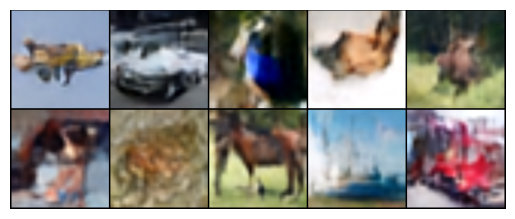

Epoch: 11/60 - loss: 1.42e+01, learning_rate: 6.84e-06


Epoch: 12/60 - loss: 1.43e+01, learning_rate: 7.60e-06


Epoch: 13/60 - loss: 1.42e+01, learning_rate: 8.29e-06


Epoch: 14/60 - loss: 1.42e+01, learning_rate: 8.88e-06


Epoch: 15/60 - loss: 1.43e+01, learning_rate: 9.36e-06


Epoch: 16/60 - loss: 1.41e+01, learning_rate: 9.71e-06


Epoch: 17/60 - loss: 1.42e+01, learning_rate: 9.93e-06


Epoch: 18/60 - loss: 1.43e+01, learning_rate: 1.00e-05


Epoch: 19/60 - loss: 1.41e+01, learning_rate: 9.99e-06


Epoch: 20/60 - loss: 1.42e+01, learning_rate: 9.94e-06


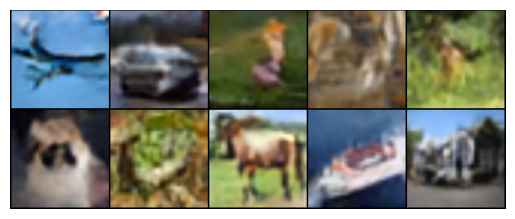

Epoch: 21/60 - loss: 1.41e+01, learning_rate: 9.87e-06


Epoch: 22/60 - loss: 1.39e+01, learning_rate: 9.78e-06


Epoch: 23/60 - loss: 1.43e+01, learning_rate: 9.65e-06


Epoch: 24/60 - loss: 1.41e+01, learning_rate: 9.50e-06


Epoch: 25/60 - loss: 1.41e+01, learning_rate: 9.33e-06


Epoch: 26/60 - loss: 1.43e+01, learning_rate: 9.13e-06


Epoch: 27/60 - loss: 1.40e+01, learning_rate: 8.91e-06


Epoch: 28/60 - loss: 1.41e+01, learning_rate: 8.66e-06


Epoch: 29/60 - loss: 1.41e+01, learning_rate: 8.40e-06


Epoch: 30/60 - loss: 1.41e+01, learning_rate: 8.12e-06


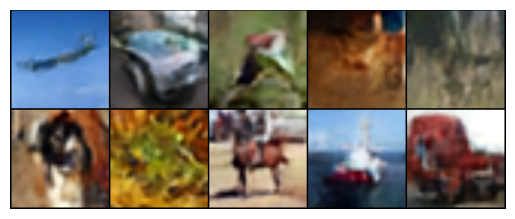

Epoch: 31/60 - loss: 1.43e+01, learning_rate: 7.82e-06


Epoch: 32/60 - loss: 1.41e+01, learning_rate: 7.50e-06


Epoch: 33/60 - loss: 1.41e+01, learning_rate: 7.17e-06


Epoch: 34/60 - loss: 1.43e+01, learning_rate: 6.82e-06


Epoch: 35/60 - loss: 1.41e+01, learning_rate: 6.47e-06


KeyboardInterrupt: 

In [20]:
for epoch in range(total_epochs):
    model.train()

    avg_loss = 0.
    p_bar = progress_bar(train_loader, leave=False)
    for images, labels in p_bar:
        images = encode_images(images)
        labels = labels.cuda()
        
        with torch.autocast("cuda") and torch.enable_grad():
            # noised images
            t = torch.randint(low=1, high=noise_steps, size=(images.shape[0],)).cuda()
            x_t, noise = noise_images(images, t)
            # dropout
            if np.random.random() < 0.1:
                labels = None
            # forward pass
            predicted_noise = model(x_t, t, labels)
            # calculate loss
            loss = torch.nn.functional.mse_loss(noise, predicted_noise)
        # backward pass
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        ema.step_ema(ema_model, model)
        scheduler.step()
        # logger
        p_bar.comment = f"loss: {loss.item():.2e}, learning_rate: {scheduler.get_last_lr()[0]:.2e}"
        avg_loss += loss
    
    print(f"Epoch: {epoch + 1}/{total_epochs} - loss: {avg_loss.mean().item():.2e}, learning_rate: {scheduler.get_last_lr()[0]:.2e}")

    # callbacks
    if (epoch + 1) % log_every_epoch == 0:
        log_samples()
        # save_checkpoint(checkpoint_path="diffusion_models_v2")

In [24]:
save_checkpoint("diffusion_models")

In [25]:
load_models("diffusion_models")

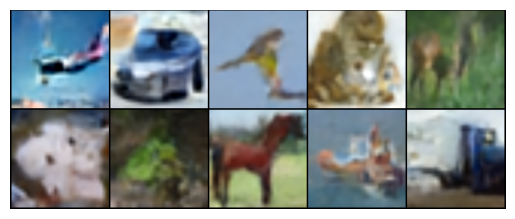

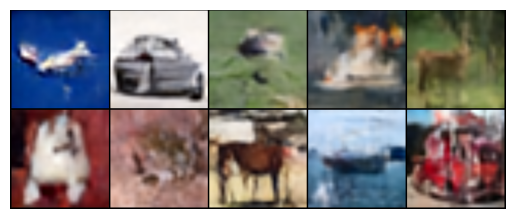

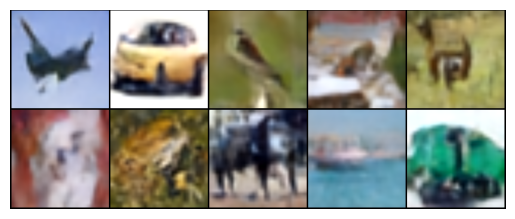

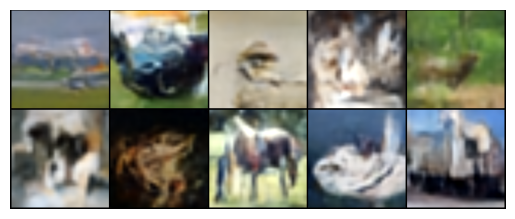

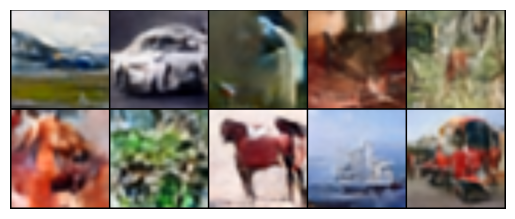

In [26]:
for i in range(5):
    log_samples()

In [27]:
load_models("diffusion_models_v2")

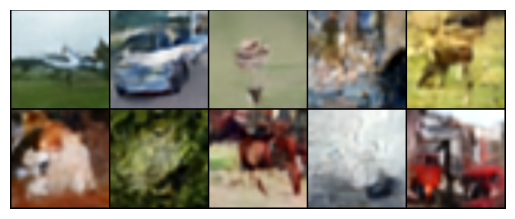

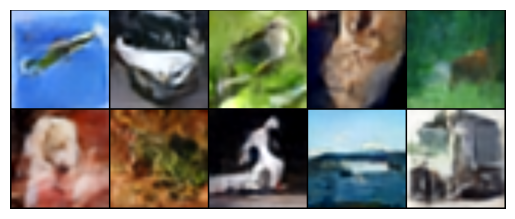

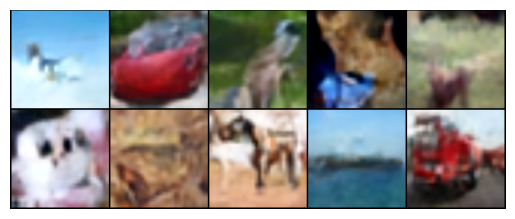

KeyboardInterrupt: 

In [28]:
for i in range(5):
    log_samples()